# Question 2

## 2.1 GMM: Gaussian Mixture Models

In [3]:
import pandas as pd
import numpy as np
from scipy.stats import multivariate_normal

### 2.1.1 Find the parameters of GMM associated with the customer-dataset, using the EM method. Vary the number of components, and observe the results.

In [4]:
data=pd.read_csv("SMAI-Dataset-customer-dataset/data.csv")

In [6]:
X=[]

for j in range(2000):
    X.append([])
    for i in data:
        if(i=="Index"):
            continue
        X[j].append(data[i][j])

X=np.array(X)

In [7]:

def PCA(X):
    data=X.reshape(X.shape[0],-1)
    mean = np.mean(data, axis=0)
    centered_data = data - mean
    cov_matrix = np.dot(centered_data.T, centered_data) / (centered_data.shape[0] - 1)
    _, s, V = np.linalg.svd(cov_matrix, hermitian=True)
    sorted_indices = np.argsort(s)[::-1]
    # return (sorted_indices,V,centered_data)
    top_indices = sorted_indices[:3]
    eig_vals = V[:, top_indices]
    reduced_data = np.dot(centered_data, eig_vals)
    return reduced_data

X=PCA(X)

[[  138.19443131   -24.15901291   -24.70787198]
 [ 1002.16427485  -288.44010067  -200.59886089]
 [-1068.16065284   307.09178456   213.53826842]
 ...
 [-1170.57920779   327.60294767   232.58064567]
 [ -782.05559341   215.43481602   153.9485198 ]
 [-1780.65218416   497.43691713   353.4169565 ]]


In [115]:
class GMM:
    def __init__(self, number_of_components, max_iter):
        self.number_of_components = number_of_components
        self.max_iter = max_iter
        self.weights = None
        self.means = None
        self.covariances = None

    def fit(self, X):
        n_samples, n_features = X.shape
        self.weights = np.ones(self.number_of_components) / self.number_of_components
        self.means = X[np.random.choice(n_samples, self.number_of_components, replace=False)]
        self.covariances = [np.cov(X.T) for _ in range(self.number_of_components)]

        for _ in range(self.max_iter):
            responsibilities = self._compute_responsibilities(X)

            self._update_parameters(X, responsibilities)

    def _compute_responsibilities(self, X):
        responsibilities = np.zeros((X.shape[0], self.number_of_components))
        for i in range(self.number_of_components):
            responsibilities[:, i] = (self.weights[i] * multivariate_normal.pdf(X, mean=self.means[i], cov=self.covariances[i]))
        responsibilities /= responsibilities.sum(axis=1, keepdims=True)
        return responsibilities

    def _update_parameters(self, X, responsibilities):
        Nk = responsibilities.sum(axis=0)
        self.weights = Nk / X.shape[0]
        self.means = np.dot(responsibilities.T, X) / Nk[:, np.newaxis]
        for i in range(self.number_of_components):
            diff = X - self.means[i]
            cov = np.dot(responsibilities[:, i] * diff.T, diff) / Nk[i]
            self.covariances[i] = cov

    def predict(self, X):
        responsibilities = self._compute_responsibilities(X)
        return np.argmax(responsibilities, axis=1)

    def return_params(self):
        responsibilities = self._compute_responsibilities(X)
        log_likelihoods = np.sum(np.log(np.sum(responsibilities, axis=1)))
        return (self.means,self.weights,self.covariances,log_likelihoods)

    def compute_bic(self, X):
        mean = X.mean(axis=0)
        std = X.std(axis=0)
        std[std == 0] = 1.0
        X = (X - mean) / std
        n_samples, n_features = X.shape
        k = (self.number_of_components - 1) + self.number_of_components * n_features + self.number_of_components * n_features * (n_features + 1) / 2
        
        log_likelihood = 0.0
        for i in range(n_samples):
            prob_x_i = 0.0
            for j in range(self.number_of_components):                
                pdf = multivariate_normal.pdf(X[i], mean=self.means[j], cov=self.covariances[j])
                prob_x_i += self.weights[j] * pdf

            log_likelihood += np.log(prob_x_i)
        bic = 2 * log_likelihood + k * np.log(n_samples)
        return bic

    def compute_aic(self, X):
        mean = X.mean(axis=0)
        std = X.std(axis=0)
        std[std == 0] = 1.0
        X = (X - mean) / std
        n_samples, n_features = X.shape
        k = (self.number_of_components - 1) + self.number_of_components * n_features + self.number_of_components * n_features * (n_features + 1) / 2
        
        log_likelihood = 0.0
        for i in range(n_samples):
            prob_x_i = 0.0
            for j in range(self.number_of_components):                
                pdf = multivariate_normal.pdf(X[i], mean=self.means[j], cov=self.covariances[j])
                prob_x_i += self.weights[j] * pdf

            log_likelihood += np.log(prob_x_i)
        aic = 2 * log_likelihood + 2 * k
        return aic


In [9]:
for cluster in range(1,6):
    g=GMM(cluster,100)
    g.fit(X)
    mean,weight,cov,log_likelihood=g.return_params()
    print(log_likelihood)

0.0
-8.881784197001252e-16
-1.0658141036401503e-14
-2.7977620220553945e-14
-2.5979218776228663e-14


### 2.1.2 Perform clustering on the wine-dataset using Gaussian Mixture Model (GMM) and K-Means algorithms. Find the optimal number of clusters for GMM using BIC (Bayesian Information Criterion) and AIC (Akaike Information Criterion). Reduce the dataset dimension to 2 using Principal Component Analysis (PCA), plot scatter plots for each of the clustering mentioned above, analyze your observations and report them. Also, compute the silhouette scores for each clustering and compare the results.

In [10]:
from sklearn.datasets import load_wine
wine = load_wine()
X = wine.data
y = wine.target

In [80]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

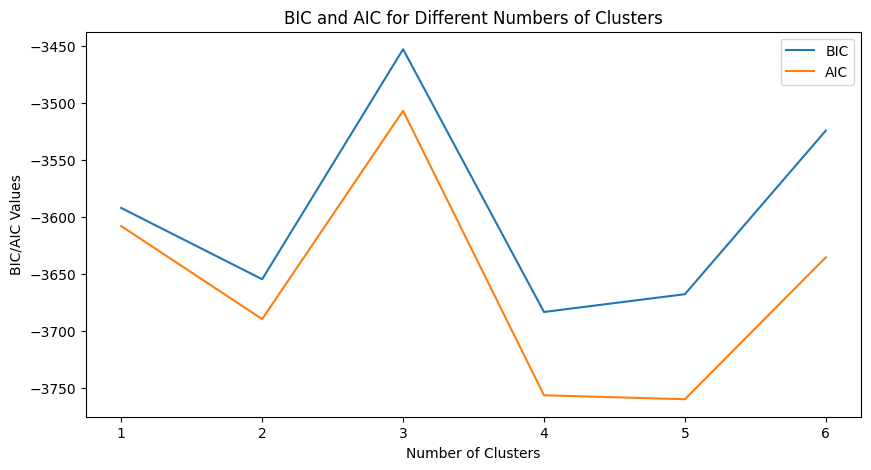

In [122]:
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

n_components_range=[i for i in range(1,7)]
bic_values=[]
aic_values=[]

for n in range(1,7):
    g=GMM(n,100)
    g.fit(X_pca)
    bic_values.append(g.compute_bic(X_pca))
    aic_values.append(g.compute_aic(X_pca))

plt.figure(figsize=(10, 5))
plt.plot(n_components_range, bic_values, label='BIC')
plt.plot(n_components_range, aic_values, label='AIC')
plt.xlabel('Number of Clusters')
plt.ylabel('BIC/AIC Values')
plt.title('BIC and AIC for Different Numbers of Clusters')
plt.legend()
plt.show()

optimal_n_components = n_components_range[np.argmin(bic_values)]

gmm=GMM(optimal_n_components,100)
gmm.fit(X_pca)
gmm_labels=gmm.predict(X_pca)

In [123]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=optimal_n_components, random_state=0)
kmeans_labels = kmeans.fit_predict(X_pca)

/home/sankalp/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


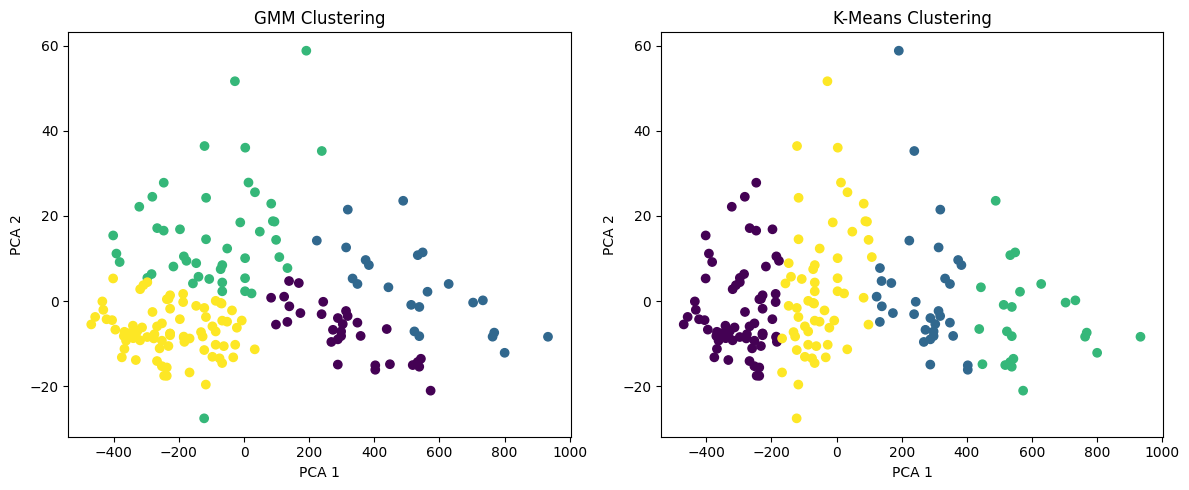

In [124]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=gmm_labels, cmap='viridis')
plt.title('GMM Clustering')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')

plt.subplot(1, 2, 2)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans_labels, cmap='viridis')
plt.title('K-Means Clustering')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')

plt.tight_layout()
plt.show()

In [125]:
from sklearn.metrics import silhouette_score

silhouette_gmm = silhouette_score(X_pca, gmm_labels)
silhouette_kmeans = silhouette_score(X_pca, kmeans_labels)

print(f"Silhouette Score for GMM: {silhouette_gmm}")
print(f"Silhouette Score for K-Means: {silhouette_kmeans}")

Silhouette Score for GMM: 0.14177757566467736
Silhouette Score for K-Means: 0.5633930017441459


### Observations

1. The silhouette score calculates the distance between each data point in a cluster and the points in its surrounding clusters. The clusters are better separated when the silhouette score is higher.

2. The silhouette score for the K means clustering maximises at 4 clusters, and the cluster graphs show that 4 clusters suit the graphs.